# COMP47590 Advanced Machine Learning
# CNN with Pytorch using Local Images & Data Augmentation


In this example we build a Convolutional Neural Network with **PyTorch**  to classify images that are stored locally. The dataset used is from Kaggle: 
* cats vs dogs https://www.kaggle.com/c/dogs-vs-cats


**Data augmentation** is a technique used to increase the size and variability of a dataset by creating new, slightly modified versions of existing data (images). This can help prevent overfitting and improve the generalization ability of a model. 

In Pytorch, data augmentation can be implemented using the **torchvision.transforms** module. This module provides various image transformations, such as resizing, cropping, flipping, rotation, and color jittering. These transformations can be combined together in a **Compose** object to create a sequence of transformations that can be applied to an input image.

In [1]:
import os 
import csv
# import cv2
import random
import numpy as np
import pandas as pd
import PIL

from sklearn import metrics

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline 

## Data Loading & Pre-processing

Set up the dataset loading and pre-processing process. We provide the name of a folder containing images. We assume that he images of different classes are contained in folders with class ids.

In [2]:
dataset_name = 'dogs-vs-cats'

# A sampling rate to allow undersampling for fast execuation
sample_rate = 0.5

# Define proportion of data for test, train and validation splits. 
train_split = 0.5
valid_split = 0.2
test_split = 0.3

# Desired dimensions of our images.
img_width, img_height = 128, 128

Compose a set of transformations to perform data augmentation for training data images. 

In [3]:
# Define the data transformations
train_transforms = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.RandomHorizontalFlip(p=0.5), # Flip the image horizontally.
    transforms.RandomVerticalFlip(p=0.5), # Flip the image vertically.
    transforms.RandomRotation(degrees=20), # Rotate the image by angle.
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), # Change the brightness, contrast and saturation of an image.
    transforms.ToTensor()
])

For test data we don't apply data augmentation transformations - so just resizing. 

In [4]:
test_transforms = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor()
])

View a demo of a transformation with a sample image.

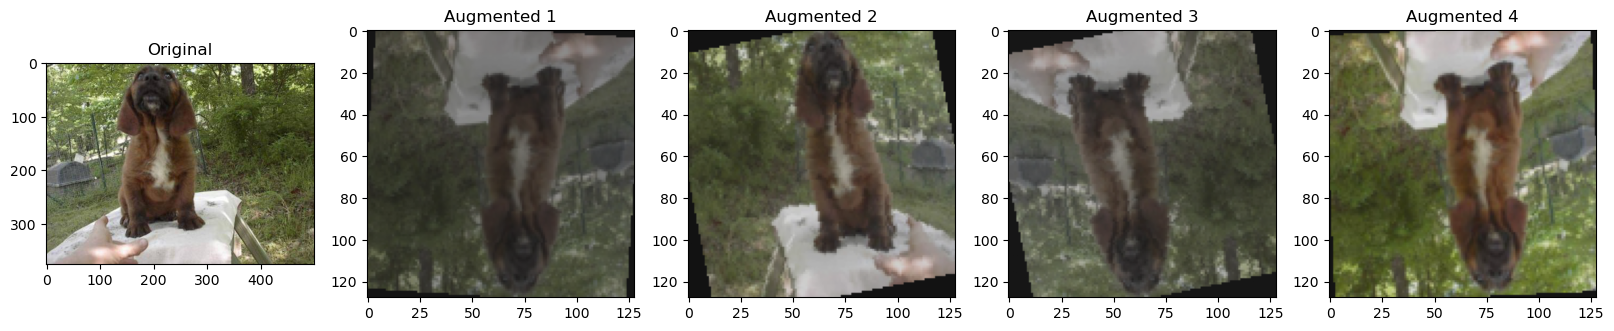

In [7]:
# Load the original image
img_path = "../Data/" + dataset_name + '/dog/dog.5.jpg'
img4plot = PIL.Image.open(img_path)

# Apply the transformations to the original image
augmented_images = [train_transforms(img4plot) for _ in range(4)]

# Plot the original image and the augmented images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
axes[0].imshow(img4plot)
axes[0].set_title('Original')

for i, aug_img in enumerate(augmented_images):
    axes[i+1].imshow(aug_img.permute(1, 2, 0))
    axes[i+1].set_title(f'Augmented {i+1}')
    
plt.show()

Partition the data in train, validation, and test partitions.

In [21]:
# Load the data
dataset = datasets.ImageFolder("../Data/" + dataset_name + "/", transform = None)

# Resample the data set
resampled_size = int(sample_rate * len(dataset))
resampled_dataset, _ = random_split(dataset, [resampled_size, len(dataset) - resampled_size])

# Split the data into train, validation and test sets
test_size = int(test_split * len(resampled_dataset))
train_val_size = int(0.7 * len(resampled_dataset))
train_val_size = len(resampled_dataset) - test_size
train_val_dataset, test_dataset = random_split(resampled_dataset, [train_val_size, test_size])

train_size = int((train_split/(train_split + valid_split)) * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

We create a custom dataset object to allow us associate the transformation with the data loader. 

In [22]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x, y = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x, y

In [23]:
train_dataset = CustomDataset(train_dataset, transform=train_transforms)
val_dataset = CustomDataset(val_dataset, transform=test_transforms)
test_dataset = CustomDataset(test_dataset, transform=test_transforms)

Create Pytorch **DataLoader** objects to stream train, validation, and test sets.  

In [24]:
batch_size = 32  # Batch size used during training

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

Print a few randomly sampled example images.

In [25]:
items = iter(train_loader)
image, label = next(items)

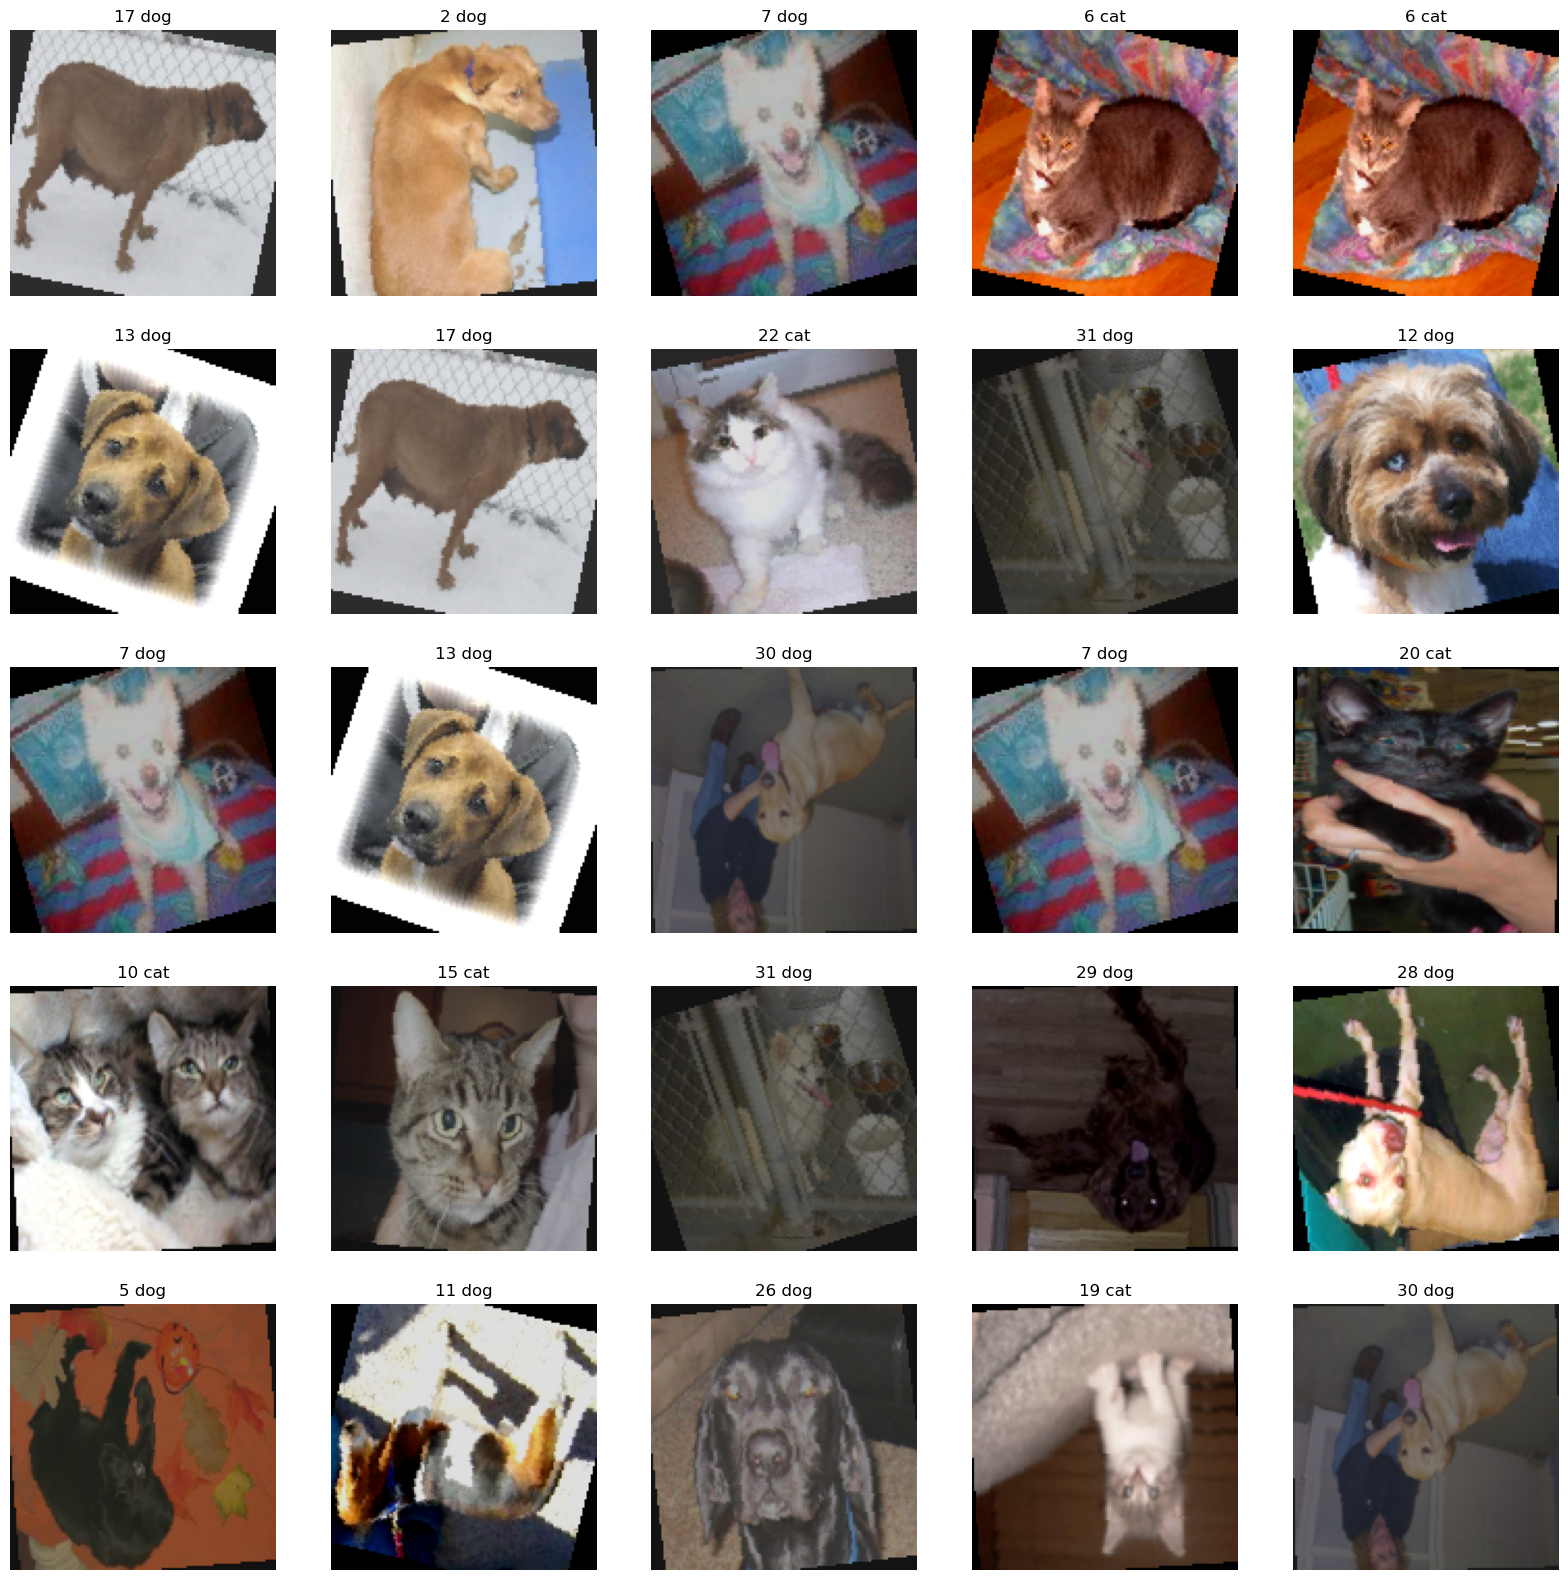

In [27]:
pltsize=4
row_images = 5
col_images = 5
label_names = dataset.classes
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

np_image = image.numpy()
np_label = label.numpy()
for i in range(row_images * col_images):
    i_rand = random.randint(0, len(image) - 1)
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(np_image[i_rand], (1, 2, 0)))
    plt.title((str(i_rand) + " " + label_names[np_label[i_rand]]))

plt.show()

In [28]:
dataset.class_to_idx

{'cat': 0, 'dog': 1}

## Define Model

Define simple CNN model architecture. Note the use of a **Sequential** object to which we can add layers as a simple way to structure models. 

In [29]:
class CNN(nn.Module):
    
    # Defining the Constructor
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        
        # In the init function, we define the layers will be used in our model
        # We first create a sequential model object to store the layers
        self.layers = nn.Sequential()
        
        # The first convolutional layer takes 3 input channels and includes 12 convolutions
        self.layers.add_module('conv1',
                               nn.Conv2d(in_channels=3, out_channels=12,
                                         kernel_size=3, stride=1, padding=1))

        # Add a RELU activation
        self.layers.add_module('relu1',
                               nn.ReLU())
        
        # Apply max pooling with a kernel size of 2
        self.layers.add_module('pool1', 
                               nn.MaxPool2d(kernel_size=2))
                                              
        # The second convolutional layer takes 12 input channels and includes 24 convolutions
        self.layers.add_module('conv2',
                               nn.Conv2d(in_channels=12, out_channels=24, 
                                         kernel_size=3, stride=1, padding=1))
        
        # Add a RELU activation
        self.layers.add_module('relu2', 
                               nn.ReLU())
        
        # Apply max pooling with a kernel size of 2
        self.layers.add_module('pool2', 
                               nn.MaxPool2d(kernel_size=2))

        # Apply dropout with a probability of 0.5
        self.layers.add_module('dropout1', 
                               nn.Dropout(p=0.5))
        
        # We need to flatten these in order to feed them to a fully-connected layer
        self.layers.add_module('flatten1', 
                               nn.Flatten())                               

        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. therefore, 128/2/2 is 32.
        # This means that the output of the second convolutional layer will be 32x32x24.
        self.layers.add_module('fc1',  
                               nn.Linear(in_features = 24 * 32 * 32, 
                                         out_features=256))
         
        # Add a RELU activation
        self.layers.add_module('relu3', 
                               nn.ReLU())
        
        # the final output layer                       
        self.layers.add_module('fc2', 
                               nn.Linear(in_features = 256, 
                                         out_features = num_classes))

    def forward(self, x):
       
        return self.layers(x)

Create an instance of the model class.

In [30]:
model = CNN(num_classes = len(dataset.class_to_idx))
print(model)

CNN(
  (layers): Sequential(
    (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout1): Dropout(p=0.5, inplace=False)
    (flatten1): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=24576, out_features=256, bias=True)
    (relu3): ReLU()
    (fc2): Linear(in_features=256, out_features=2, bias=True)
  )
)


## Train Model

Define the model training loop keeping track of some key attributes along the way. 

In [31]:
epochs = 5

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define lists to store the training and validation loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()

    # Initialize the training loss and accuracy for this epoch
    running_train_loss = 0.0
    running_train_corrects = 0

    running_val_loss = 0.0
    running_val_corrects = 0

    for i, (X_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Compute statistics
        running_train_loss += loss.item() * batch_size
        running_train_corrects += torch.sum(torch.argmax(outputs, dim=1) == y_train)
    
    # Compute statistics for the entire epoch
    epoch_train_loss = running_train_loss / train_size
    epoch_train_acc = running_train_corrects.item() / train_size * 100

    # Append the training statistics to the lists
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # Evaluation on validation set
    with torch.no_grad():
        for i, (X_val, y_val) in enumerate(val_loader):
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_corrects = torch.sum(torch.argmax(val_outputs, dim=1) == y_val)

            # Compute statistics
            running_val_loss += val_loss.item() * batch_size
            running_val_corrects += torch.sum(torch.argmax(val_outputs, dim=1) == y_val)

              
    # Compute statistics for the entire epoch
    epoch_val_loss = running_val_loss / val_size
    epoch_val_acc = running_val_corrects.item() / val_size * 100

    # Append the validation statistics to the lists
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_acc:.2f}%, \
          Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.2f}%')

Epoch 1/5, Training Loss: 0.6991, Training Accuracy: 54.08%,           Validation Loss: 0.6890, Validation Accuracy: 56.60%
Epoch 2/5, Training Loss: 0.6790, Training Accuracy: 57.22%,           Validation Loss: 0.6640, Validation Accuracy: 62.48%
Epoch 3/5, Training Loss: 0.6636, Training Accuracy: 60.66%,           Validation Loss: 0.6494, Validation Accuracy: 64.60%
Epoch 4/5, Training Loss: 0.6423, Training Accuracy: 63.94%,           Validation Loss: 0.6049, Validation Accuracy: 67.52%
Epoch 5/5, Training Loss: 0.6237, Training Accuracy: 65.14%,           Validation Loss: 0.6135, Validation Accuracy: 66.92%


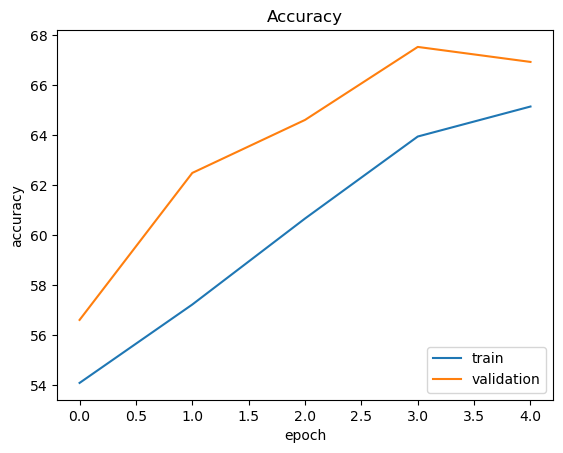

In [32]:
# Summarize history for accuracy
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
#plt.ylim((0, 1.1))
plt.show()

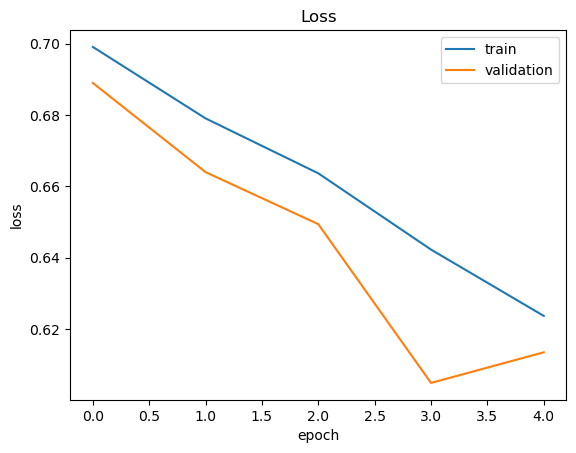

In [33]:
# Summarize history for loss
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
# plt.ylim((-0.1, 1.2))
plt.show()

## Evaluate Model

Generate some simple summary statistics of model performance. 

In [34]:
X_test_cat = []
y_true = []
y_pred = []

for i, (X_test, y_test) in enumerate(test_loader):
    test_outputs = model(X_test)
    _, preds = torch.max(test_outputs, 1)

    # Add up the predictions
    X_test_cat.extend(X_test)
    y_true.extend(y_test)
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
# Print performance details
print(metrics.classification_report(y_true, y_pred))

# Print confusion matrix 
print("Confusion Matrix")
display(pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1832
           1       0.66      0.68      0.67      1918

    accuracy                           0.66      3750
   macro avg       0.66      0.66      0.66      3750
weighted avg       0.66      0.66      0.66      3750

Confusion Matrix


Predicted     0     1   All
True                       
0          1170   662  1832
1           611  1307  1918
All        1781  1969  3750

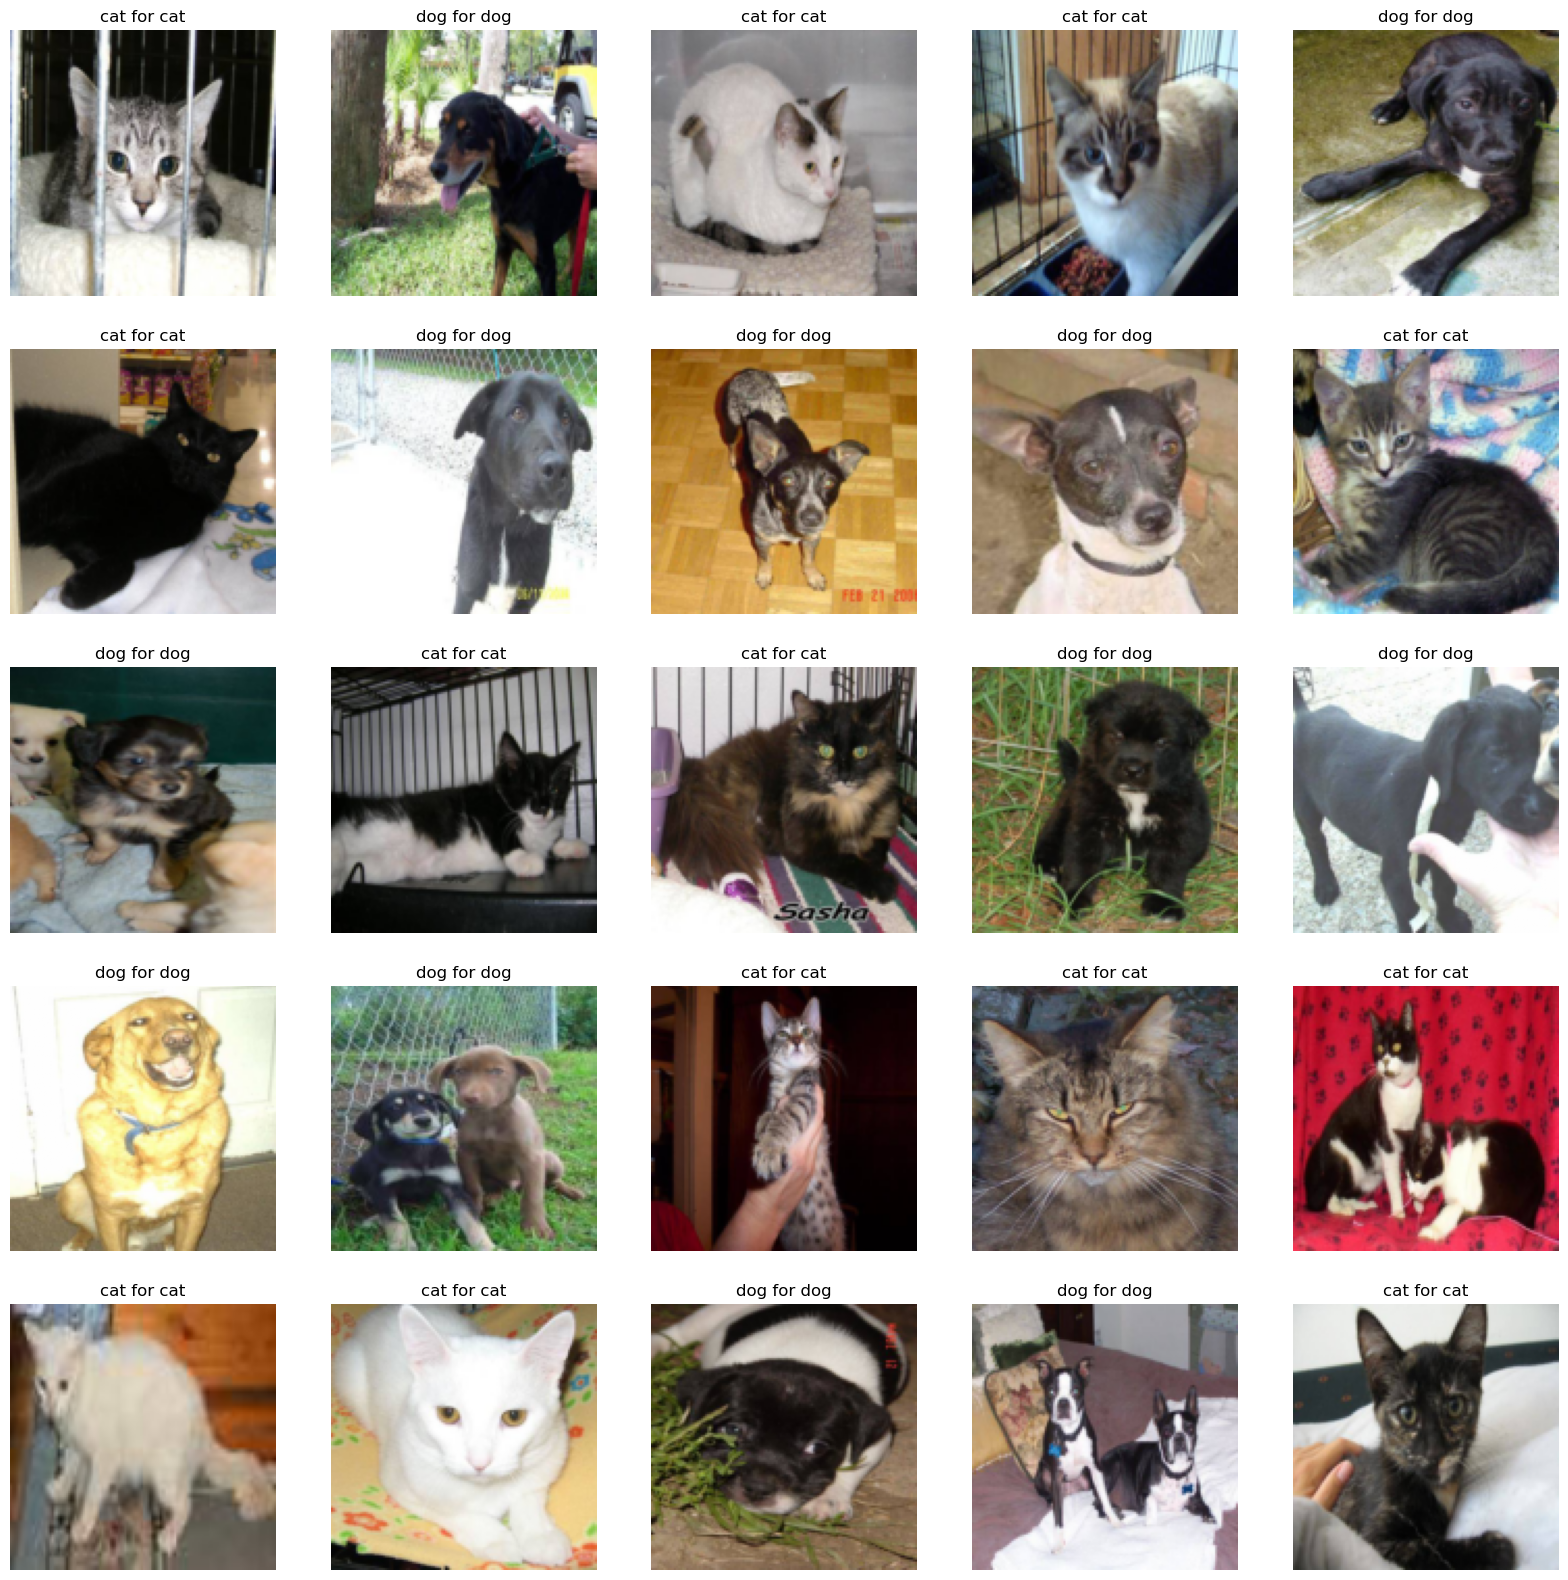

In [38]:
pltsize=4
row_images = 5
col_images = 5

maxtoshow = row_images * col_images
corrects = y_pred == y_true
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(test_size):
    if ii>=maxtoshow:
        break
    if corrects[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(np.transpose(X_test_cat[i], (1, 2, 0)))
        plt.title("{} for {}".format(label_names[y_pred[i]], label_names[y_true[i]]))
        ii = ii + 1

plt.show()

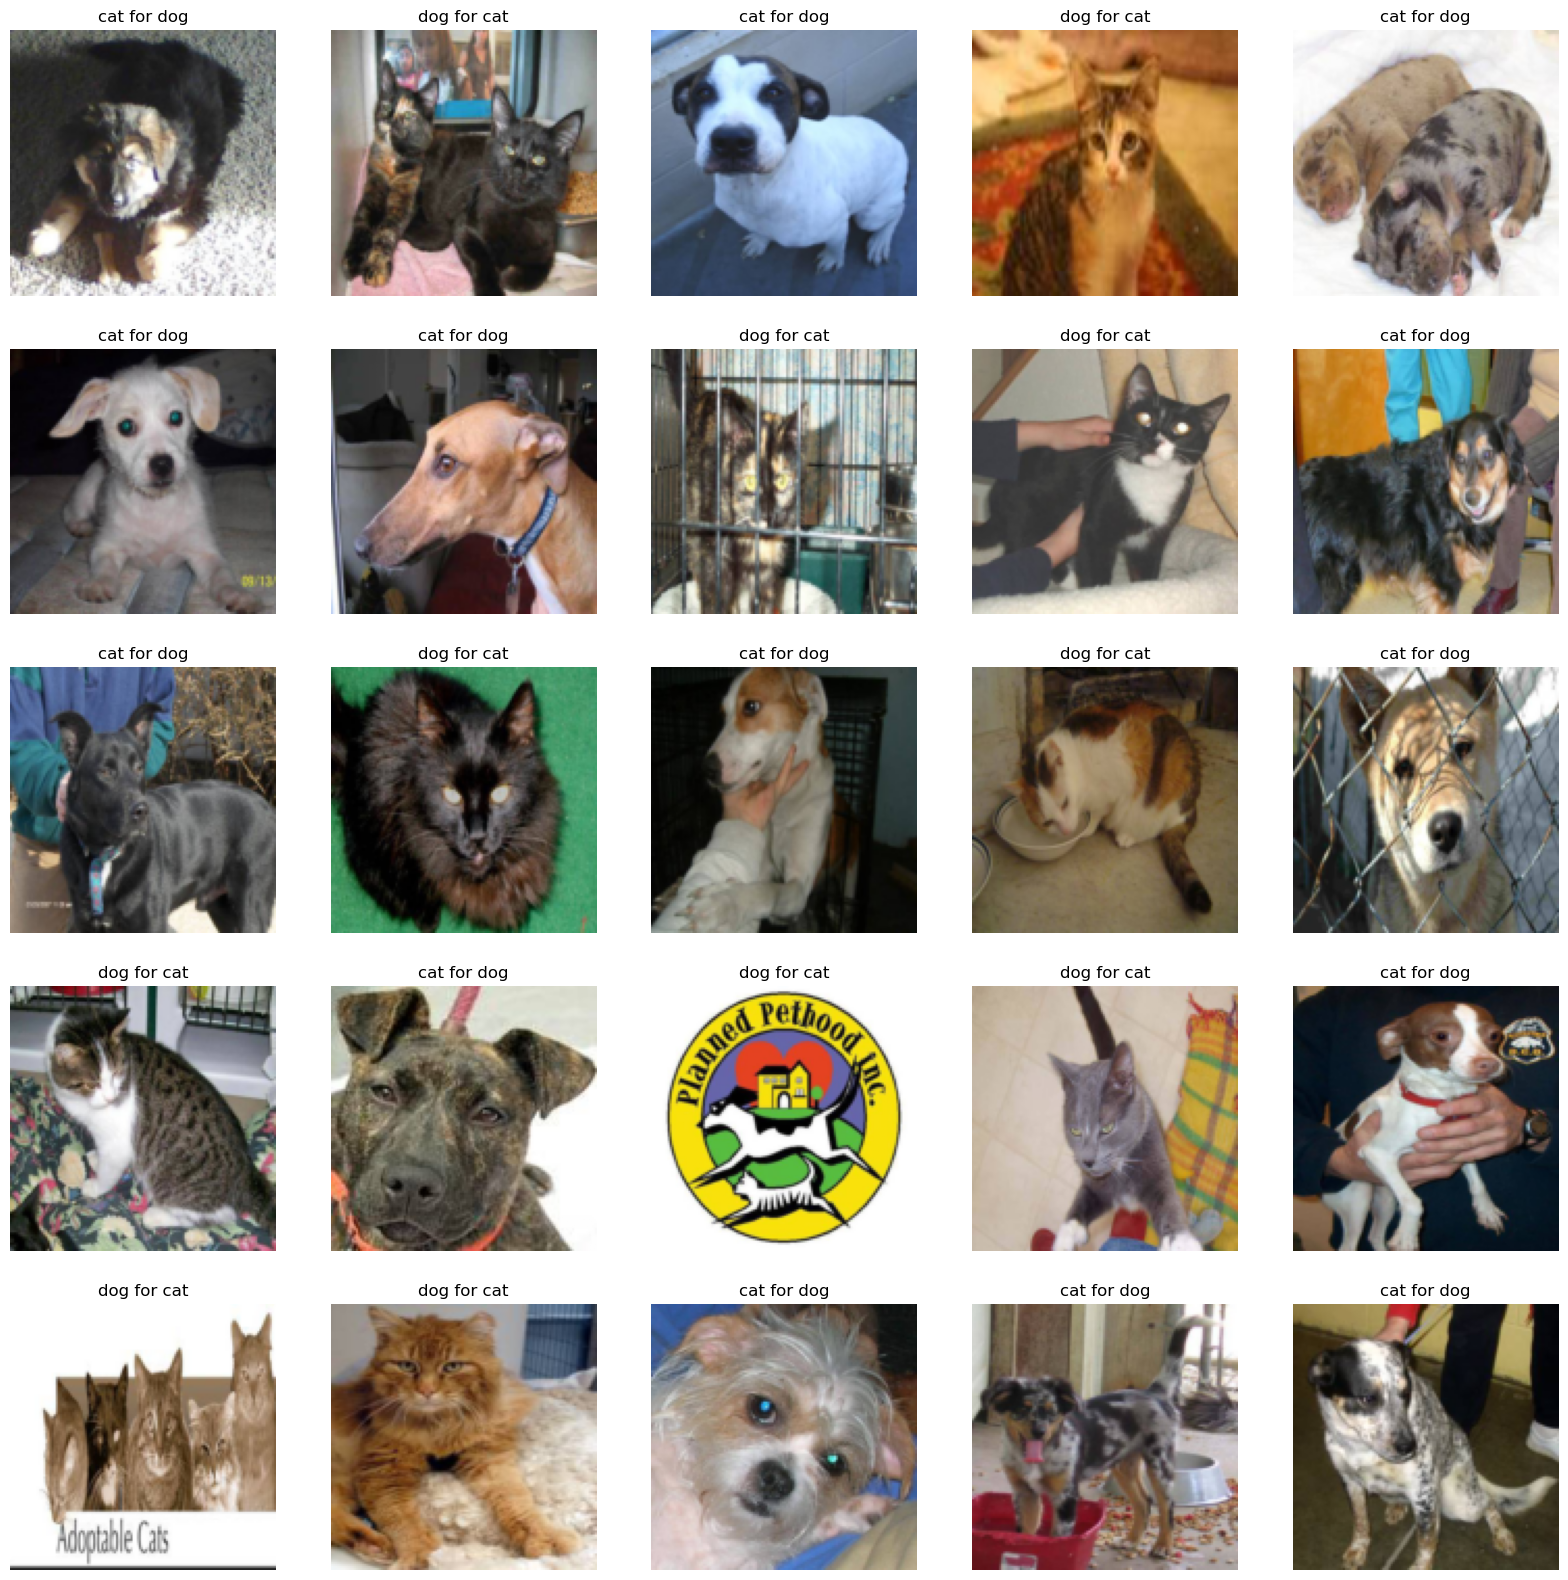

In [39]:
pltsize=4
row_images = 5
col_images = 5

maxtoshow = row_images * col_images
errors = y_pred != y_true
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(test_size):
    if ii>=maxtoshow:
        break
    if (errors[i]):
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(np.transpose(X_test_cat[i], (1, 2, 0)))
        plt.title("{} for {}".format(label_names[y_pred[i]], label_names[y_true[i]]))
        ii = ii + 1

plt.show()